In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d beosup/lung-segment -p /content/drive/MyDrive/Lab_11

Dataset URL: https://www.kaggle.com/datasets/beosup/lung-segment
License(s): CC0-1.0


In [ ]:
!unzip -q /content/drive/MyDrive/Lab_11/lung-segment.zip -d /content/drive/MyDrive/Lab_11/


⚠ Warning: Mask not found for 10.png
⚠ Warning: Mask not found for 110.png
⚠ Warning: Mask not found for 118.png
⚠ Warning: Mask not found for 150.png
⚠ Warning: Mask not found for 158.png
⚠ Warning: Mask not found for 168.png
⚠ Warning: Mask not found for 175.png
⚠ Warning: Mask not found for 178.png
⚠ Warning: Mask not found for 179.png
⚠ Warning: Mask not found for 208.png
⚠ Warning: Mask not found for 210.png
⚠ Warning: Mask not found for 219.png
⚠ Warning: Mask not found for 223.png
⚠ Warning: Mask not found for 229.png
⚠ Warning: Mask not found for 234.png
⚠ Warning: Mask not found for 256.png
⚠ Warning: Mask not found for 257.png
⚠ Warning: Mask not found for 264.png
⚠ Warning: Mask not found for 273.png
⚠ Warning: Mask not found for 276.png
⚠ Warning: Mask not found for 281.png
⚠ Warning: Mask not found for 296.png
⚠ Warning: Mask not found for 323.png
⚠ Warning: Mask not found for 331.png
⚠ Warning: Mask not found for 337.png
⚠ Warning: Mask not found for 341.png
⚠ Warning: Ma

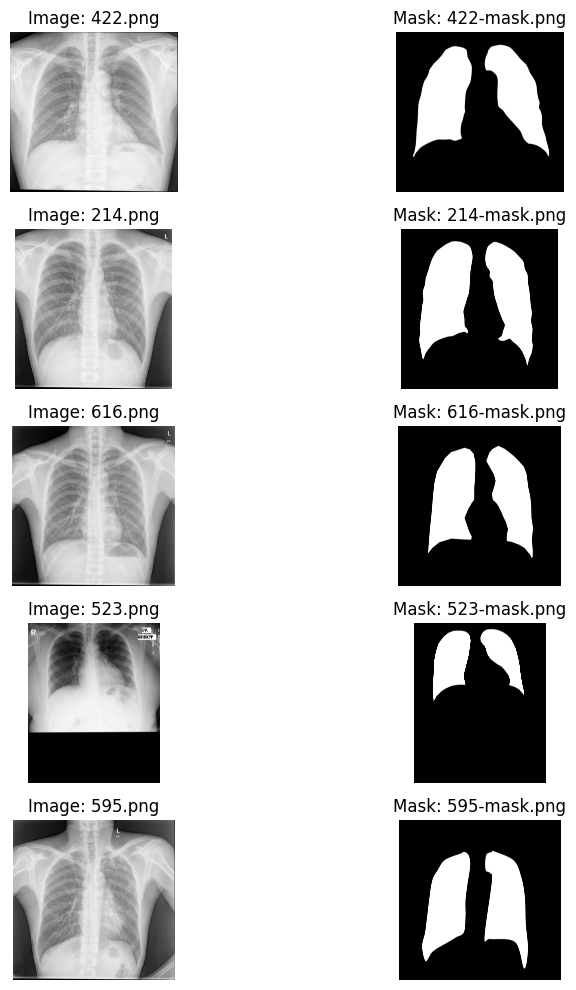

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Set paths to your dataset
image_dir = '/content/drive/MyDrive/Lab_11/images'
mask_dir = '/content/drive/MyDrive/Lab_11/masks'

# Get all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Build valid image-mask pairs
valid_pairs = []
for img_file in image_files:
    base_name = os.path.splitext(img_file)[0]       # e.g., "123"
    mask_file = base_name + '-mask.png'             # e.g., "123-mask.png"

    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    if os.path.exists(mask_path):
        valid_pairs.append((img_file, mask_file))
    else:
        print(f"⚠ Warning: Mask not found for {img_file}")

print(f"\n✅ Total valid image-mask pairs: {len(valid_pairs)}")

# Select 5 random valid pairs to visualize
sample_pairs = random.sample(valid_pairs, min(5, len(valid_pairs)))

# Plot image-mask pairs
plt.figure(figsize=(10, 10))
for i, (img_file, mask_file) in enumerate(sample_pairs):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Read image and mask
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Show image
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(image)
    plt.title(f"Image: {img_file}")
    plt.axis('off')

    # Show mask
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask: {mask_file}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Resize dimensions
IMG_SIZE = 128

# Preprocess function
def preprocess_image_mask(img_path, mask_path):
    # Load and resize image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Load and resize mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = mask.astype(np.float32) / 255.0     # Normalize
    mask = np.where(mask > 0.5, 1.0, 0.0)       # Binarize to 0 or 1

    return image, mask


In [ ]:
# Apply preprocessing to all valid pairs
X = []  # images
Y = []  # masks

for img_file, mask_file in valid_pairs:
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    image, mask = preprocess_image_mask(img_path, mask_path)
    X.append(image)
    Y.append(mask)

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

print(f"Preprocessed {len(X)} images and {len(Y)} masks.")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")


✅ Preprocessed 704 images and 704 masks.
X shape: (704, 128, 128, 3), Y shape: (704, 128, 128)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and validation (20%)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")


Train: (563, 128, 128, 3), Val: (141, 128, 128, 3)


In [ ]:
# Rebuild or load the U-Net model
model = unet_model()

# Compile with binary crossentropy and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=8
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


71/71 ━━━━━━━━━━━━━━━━━━━━ 75s 671ms/step - accuracy: 0.7459 - loss: 0.5552 - val_accuracy: 0.7546 - val_loss: 0.4327
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.8010 - loss: 0.3657 - val_accuracy: 0.9239 - val_loss: 0.1912
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.9328 - loss: 0.1716 - val_accuracy: 0.9271 - val_loss: 0.1771
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.9490 - loss: 0.1362 - val_accuracy: 0.9580 - val_loss: 0.1128
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.9624 - loss: 0.1040 - val_accuracy: 0.9655 - val_loss: 0.0906


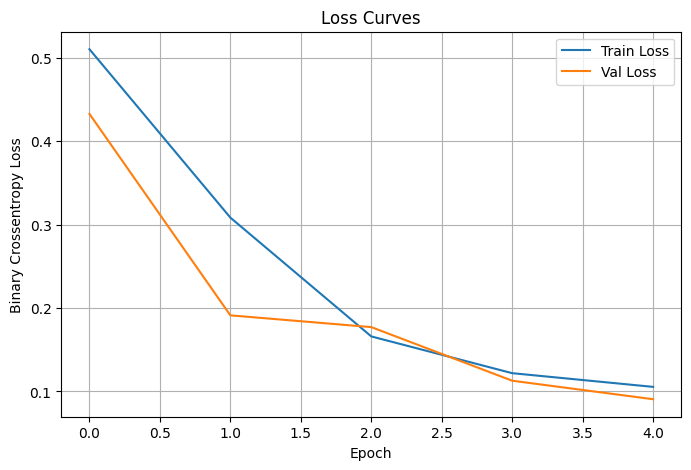

In [ ]:
# Plot training & validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Predict masks for validation set
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.float32)  # Binarize predictions


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step


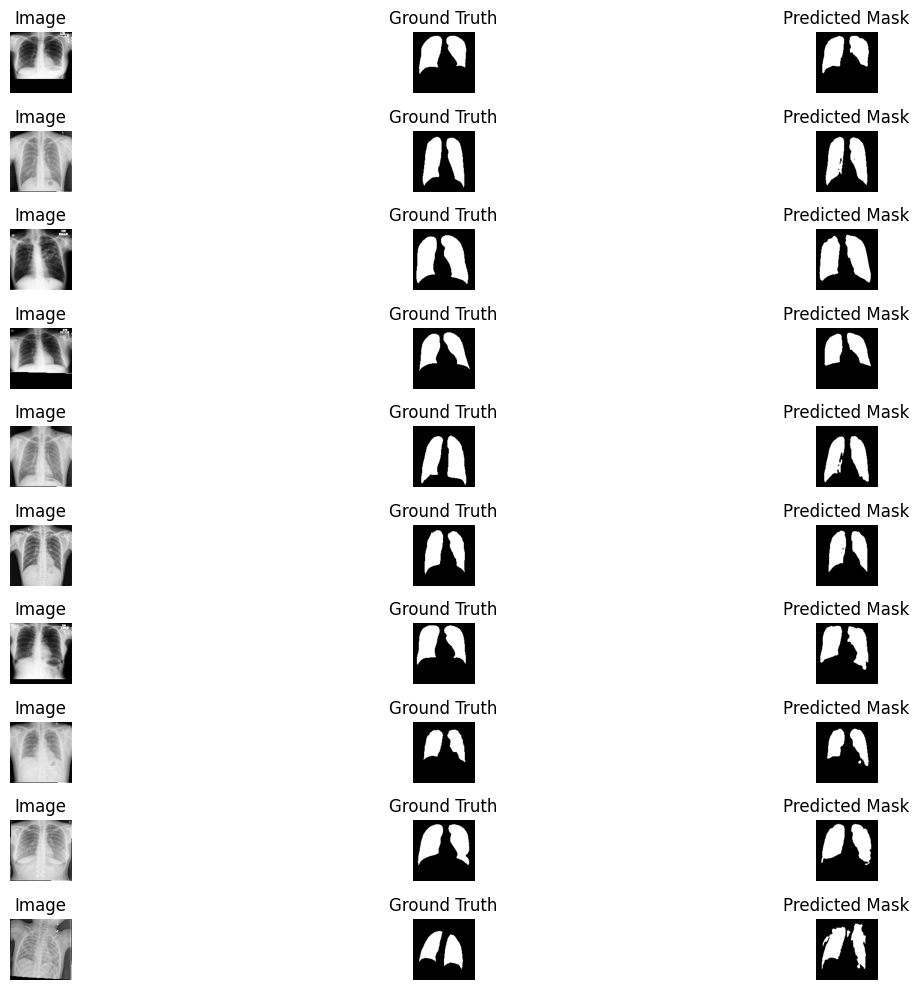

In [ ]:
import random

indices = random.sample(range(len(X_val)), 10)
plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    image = X_val[idx]
    true_mask = Y_val[idx]
    pred_mask = preds[idx].squeeze()

    # Original image
    plt.subplot(10, 3, 3*i + 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Ground truth mask
    plt.subplot(10, 3, 3*i + 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Predicted mask
    plt.subplot(10, 3, 3*i + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred):
    smooth = 1e-6
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Evaluate on 10 random samples
dice_scores = []
iou_scores = []

for idx in indices:
    y_true = Y_val[idx]
    y_pred = preds[idx]

    dice = dice_coefficient(y_true, y_pred)
    iou = iou_score(y_true, y_pred)

    dice_scores.append(dice)
    iou_scores.append(iou)

# Print results
for i in range(10):
    print(f"Sample {i+1}: Dice = {dice_scores[i]:.4f}, IoU = {iou_scores[i]:.4f}")

print(f"\n Average Dice: {np.mean(dice_scores):.4f}, Average IoU: {np.mean(iou_scores):.4f}")


Sample 1: Dice = 0.9565, IoU = 0.9167
Sample 2: Dice = 0.9651, IoU = 0.9325
Sample 3: Dice = 0.9518, IoU = 0.9081
Sample 4: Dice = 0.9401, IoU = 0.8870
Sample 5: Dice = 0.9092, IoU = 0.8335
Sample 6: Dice = 0.9422, IoU = 0.8907
Sample 7: Dice = 0.9045, IoU = 0.8256
Sample 8: Dice = 0.9150, IoU = 0.8433
Sample 9: Dice = 0.9351, IoU = 0.8782
Sample 10: Dice = 0.7280, IoU = 0.5724

 Average Dice: 0.9148, Average IoU: 0.8488



--- Training on FULL dataset ---
Epoch 1/5
71/71 - 38s - 539ms/step - accuracy: 0.7406 - loss: 0.4938 - val_accuracy: 0.7550 - val_loss: 0.4062
Epoch 2/5
71/71 - 15s - 214ms/step - accuracy: 0.8563 - loss: 0.3183 - val_accuracy: 0.8458 - val_loss: 0.2788
Epoch 3/5
71/71 - 15s - 216ms/step - accuracy: 0.7610 - loss: 0.5518 - val_accuracy: 0.8123 - val_loss: 0.3964
Epoch 4/5
71/71 - 20s - 286ms/step - accuracy: 0.8519 - loss: 0.3286 - val_accuracy: 0.9171 - val_loss: 0.2164
Epoch 5/5
71/71 - 15s - 209ms/step - accuracy: 0.9321 - loss: 0.1811 - val_accuracy: 0.9414 - val_loss: 0.1560

--- Training on SMALL subset (100) ---
Epoch 1/5
13/13 - 42s - 3s/step - accuracy: 0.7121 - loss: 0.6160 - val_accuracy: 0.7478 - val_loss: 0.5839
Epoch 2/5
13/13 - 11s - 846ms/step - accuracy: 0.7537 - loss: 0.5290 - val_accuracy: 0.7478 - val_loss: 0.4908
Epoch 3/5
13/13 - 5s - 406ms/step - accuracy: 0.7537 - loss: 0.4603 - val_accuracy: 0.7478 - val_loss: 0.4320
Epoch 4/5
13/13 - 5s - 376ms/step - accura

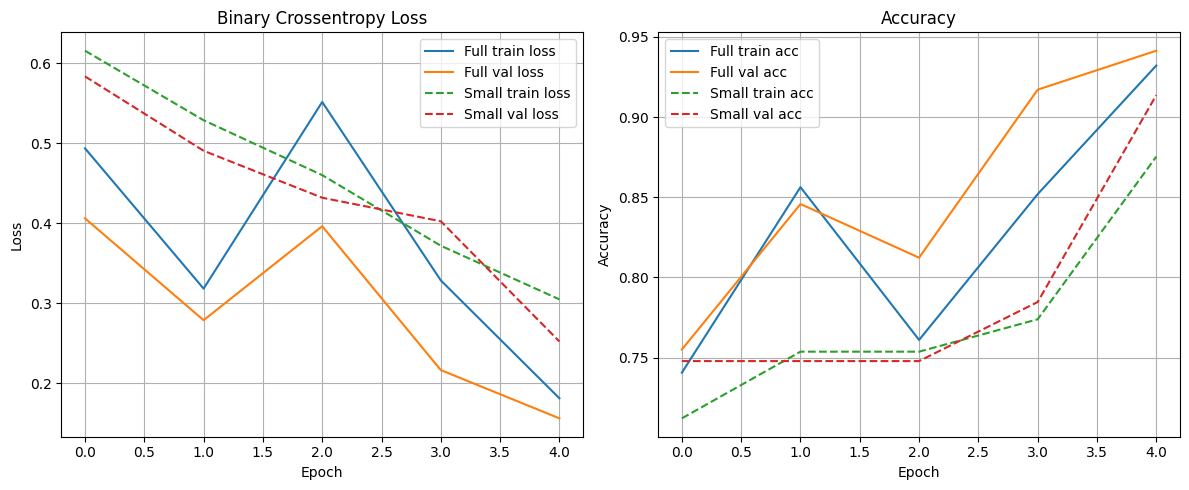

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# 1) Modified U-Net with 3 convs per block
def unet_3conv(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    def up_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    u6 = up_block(b, c4, 512)
    u7 = up_block(u6, c3, 256)
    u8 = up_block(u7, c2, 128)
    u9 = up_block(u8, c1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(u9)
    return models.Model(inputs, outputs)

# Helper to compile & fit
def compile_and_train(model, X_tr, Y_tr, X_va, Y_va, desc, epochs=5):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    print(f"\n--- Training on {desc} ---")
    history = model.fit(
        X_tr, Y_tr,
        validation_data=(X_va, Y_va),
        epochs=epochs,
        batch_size=8,
        verbose=2
    )
    return history

# 2) Train on full data
model_full = unet_3conv()
hist_full = compile_and_train(model_full, X_train, Y_train, X_val, Y_val, "FULL dataset")

# 3) Train on small subset (first 100 samples)
subset_size = min(100, X_train.shape[0])
X_sub, Y_sub = X_train[:subset_size], Y_train[:subset_size]
model_small = unet_3conv()
hist_small = compile_and_train(model_small, X_sub, Y_sub, X_val, Y_val, f"SMALL subset ({subset_size})")

# 4) Plot losses and accuracies
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(hist_full.history['loss'],   label='Full train loss')
plt.plot(hist_full.history['val_loss'], label='Full val loss')
plt.plot(hist_small.history['loss'],   label='Small train loss',    linestyle='--')
plt.plot(hist_small.history['val_loss'], label='Small val loss',    linestyle='--')
plt.title('Binary Crossentropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(hist_full.history['accuracy'],   label='Full train acc')
plt.plot(hist_full.history['val_accuracy'], label='Full val acc')
plt.plot(hist_small.history['accuracy'],   label='Small train acc',    linestyle='--')
plt.plot(hist_small.history['val_accuracy'], label='Small val acc',    linestyle='--')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
